# Data Science Project: EEG Epileptic Spike Detection

The data used in this project varies by step. In the first step, we have access to 400 epileptic spike data series (positive instances) and 2000 normal data series (negative instances) from experiment 1. There are 5x768 sample points in
each data series.

In the second step, we get more 400 epileptic spike data series (positive instances) and 2000 normal data series (negative instances) from experiment 2 in addition to the 400 positives and 2000 negatives which we already have from step 1. In this step we have so 800 epileptic spike data series (positive instances) and 4000 normal data series (negative instances) from both of experiments.

A test set of 100 epileptic spike data series and 500 normal data series from both experiments 1 and 2 is provided, for a total of 200 positive and 1000 negative series for both step 1 and 2.

<a id='installing-spark'></a>
### Installing Spark

Install Dependencies:


1.   Java 8
2.   Apache Spark with hadoop and
3.   Findspark (used to locate the spark in the system)


In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

Set Environment Variables:

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [3]:
!ls

sample_data  spark-3.1.1-bin-hadoop3.2	spark-3.1.1-bin-hadoop3.2.tgz


In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

<a id='exploring-the-dataset'></a>
## Library

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold,GridSearchCV,cross_validate
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

<a id='exploring-the-dataset'></a>
## Exploring the Dataset

<a id='loading-the-dataset'></a>
### Loading the Dataset

Connect to drive to get files

In [6]:
# Mount data from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
train_positive_ex1 = np.fromfile('/content/drive/My Drive/DS/exp1-train-400pos.bin', dtype=np.float32).reshape([400,5,768])
train_negative_ex1 = np.fromfile('/content/drive/My Drive/DS/exp1-train-2000neg.bin', dtype=np.float32).reshape([2000,5,768])
train_positive_ex2 = np.fromfile('/content/drive/My Drive/DS/exp2-train-400pos.bin', dtype=np.float32).reshape([400,5,768])
train_negative_ex2 = np.fromfile('/content/drive/My Drive/DS/exp2-train-2000neg.bin', dtype=np.float32).reshape([2000,5,768])


print(train_positive_ex1.shape)
print(train_negative_ex1.shape)
print(train_positive_ex2.shape)
print(train_negative_ex2.shape)

(400, 5, 768)
(2000, 5, 768)
(400, 5, 768)
(2000, 5, 768)


Concatenate 4 files datasets pour create train data

In [25]:
# Concatenate data for both experiments and classes
X = np.concatenate([train_positive_ex1, train_negative_ex1, train_positive_ex2, train_negative_ex2], axis=0)

# Create target labels: positive (1) and negative (0)
y_positive_ex1 = np.ones(400)
y_negative_ex1 = np.zeros(2000)
y_positive_ex2 = np.ones(400)
y_negative_ex2 = np.zeros(2000)

y = np.concatenate([y_positive_ex1, y_negative_ex1, y_positive_ex2, y_negative_ex2])

# Verify shapes of X_train and y_train
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (4800, 5, 768)
y shape: (4800,)


Reshape train data from 3 dimensions to 2 dimensions

In [26]:
# Reshape X and y to have the same number of samples
X_reshaped = X.reshape(4800, -1)  # Reshape to (4800, 5*768)
y_reshaped = y
X_reshaped.shape

(4800, 3840)

<a id='loading-the-dataset'></a>
### Plot data

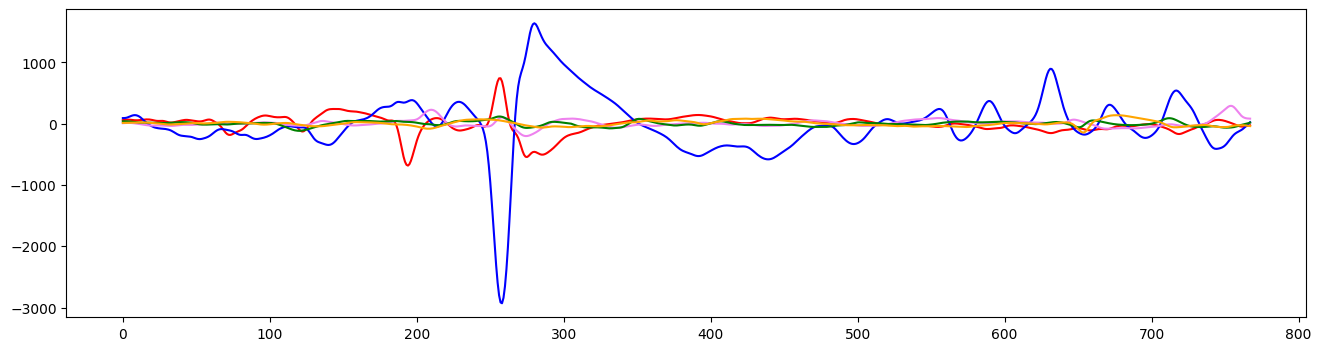

In [15]:
# cas positive ex1
y = train_positive_ex1[1][0]
y2 = train_positive_ex1[1][1]
y3 = train_positive_ex1[1][2]
y4 = train_positive_ex1[1][3]
y5 = train_positive_ex1[1][4]
# Plot lists and show them
plt.figure(1, figsize=(16, 4))
plt.plot(y, 'red')
plt.plot(y2, 'blue')
plt.plot(y3, 'violet')
plt.plot(y4, 'green')
plt.plot(y5, 'orange')
plt.show()


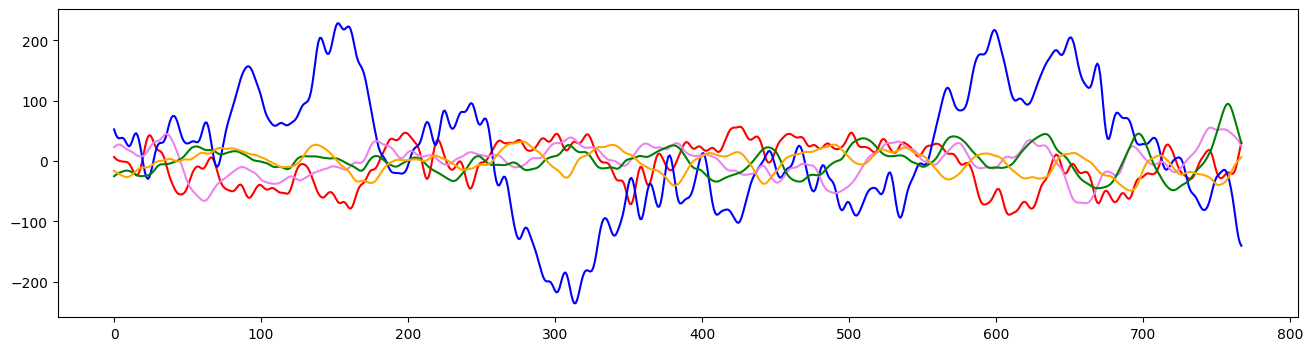

In [16]:
# cas negative ex1
y = train_negative_ex1[0][0]
y2 = train_negative_ex1[0][1]
y3 = train_negative_ex1[0][2]
y4 = train_negative_ex1[0][3]
y5 = train_negative_ex1[0][4]
# Plot lists and show them
plt.figure(1, figsize=(16, 4))
plt.plot(y, 'red')
plt.plot(y2, 'blue')
plt.plot(y3, 'violet')
plt.plot(y4, 'green')
plt.plot(y5, 'orange')
plt.show()

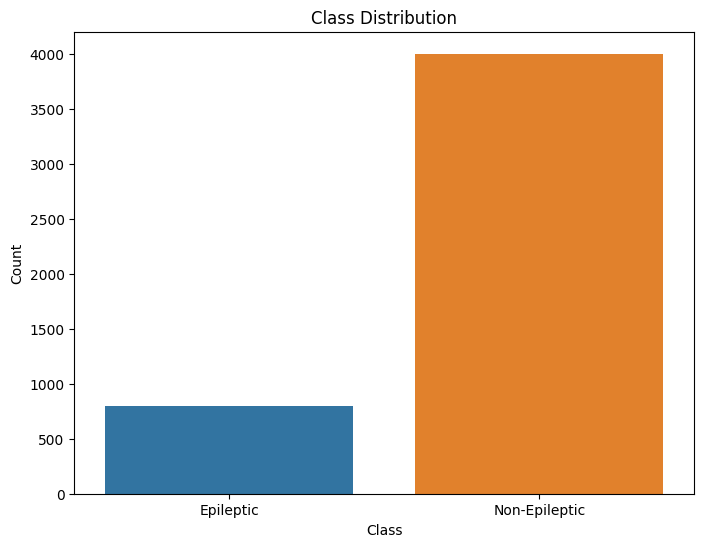

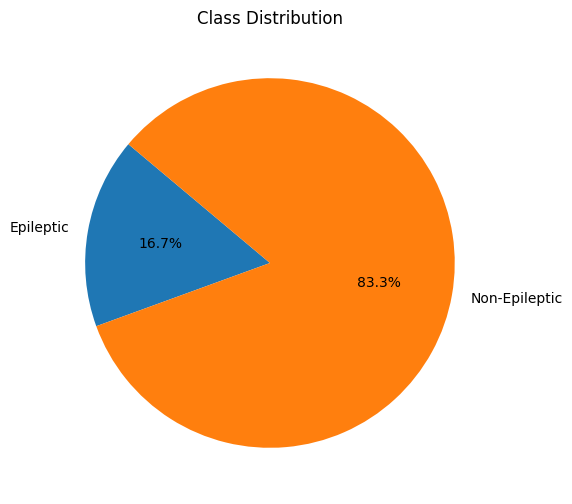

In [17]:
# Number of data points in each class
negative_count = 4000
positive_count = 800

# Create labels and counts
labels = ['Epileptic', 'Non-Epileptic']
counts = [positive_count, negative_count]

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.show()

In the context of our data science project, a notable distinction emerges between our datasets: one containing 4000 instances of non-epileptic spike series, and the other encompassing 800 instances of epileptic spike series. Evidently, a stark class imbalance issue is evident within the dataset, as highlighted in Figure above, which visualizes this skewed distribution.


<a id='loading-the-dataset'></a>
### Split data

In [35]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, test_size=1 - train_ratio, stratify=y_reshaped)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

print(x_train.shape, x_val.shape, x_test.shape)

(3600, 3840) (720, 3840) (480, 3840)


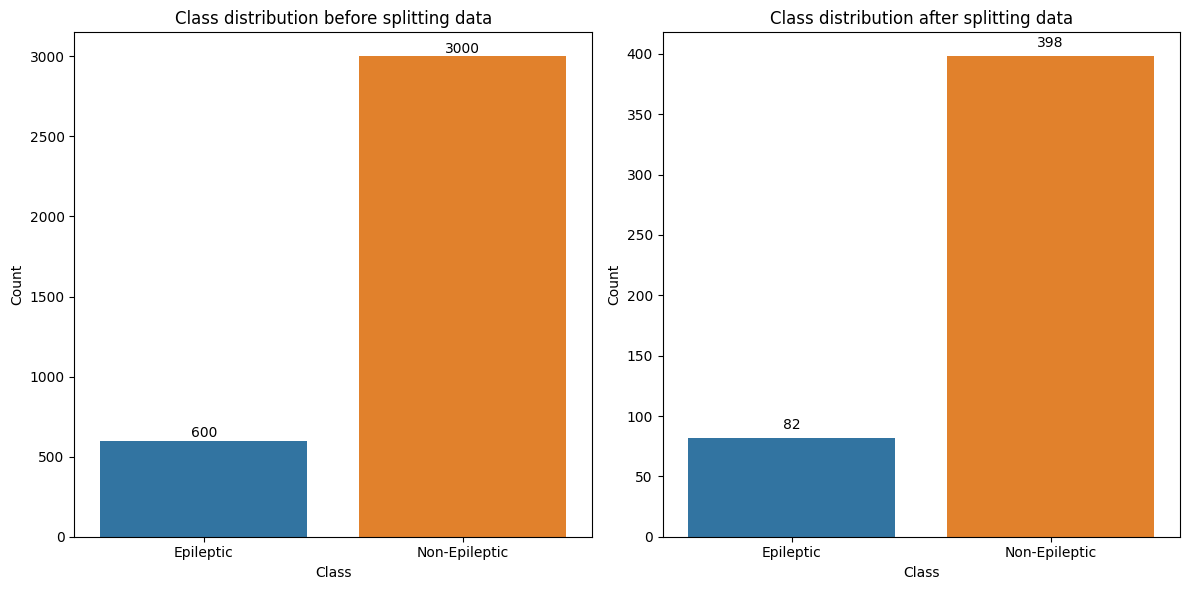

In [40]:
# Create labels and counts
labels = ['Epileptic', 'Non-Epileptic']
counts_before = [np.count_nonzero(y_train== 1), np.count_nonzero(y_train== 0)]
counts_after = [np.count_nonzero(y_test== 1), np.count_nonzero(y_test== 0)]

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First subplot (Class distribution before splitting data)
sns.barplot(x=labels, y=counts_before, ax=axes[0])
for i, count in enumerate(counts_before):
    axes[0].text(i, count + 5, str(count), ha='center', va='bottom')

axes[0].set_title('Class distribution before splitting data')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# Second subplot (Class distribution after splitting data)
sns.barplot(x=labels, y=counts_after, ax=axes[1])
for i, count in enumerate(counts_after):
    axes[1].text(i, count + 5, str(count), ha='center', va='bottom')

axes[1].set_title('Class distribution after splitting data')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

<a id='exploring-the-dataset'></a>
## Resampling techniques

In [33]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [60]:
x_train_list = []
y_train_list = []

### Strategy 1: Random Oversampling

In [61]:
# Perform random oversampling
ros = RandomOverSampler(random_state=0)
x_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)
x_train_list.append(x_train_ros)
y_train_list.append(y_train_ros)
print(x_train_ros.shape, y_train_ros.shape, np.count_nonzero(y_train_ros== 0))

(6000, 3840) (6000,) 3000


### Strategy 2: Random Undersampling

In [62]:
# Perform random undersampling
rus = RandomUnderSampler(random_state=0)
x_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)
x_train_list.append(x_train_rus)
y_train_list.append(y_train_rus)
print(x_train_rus.shape, y_train_rus.shape, np.count_nonzero(y_train_rus== 0))

(1200, 3840) (1200,) 600


### Strategy 3: SMOTE

In [63]:
# Perform SMOTE
smote = SMOTE()
x_train_sm, y_train_sm = smote.fit_resample(x_train, y_train)
x_train_list.append(x_train_sm)
y_train_list.append(y_train_sm)
print(x_train_sm.shape, y_train_sm.shape, np.count_nonzero(y_train_sm== 0))

(6000, 3840) (6000,) 3000


### Strategy 4: ADASYN

In [64]:
# Perform ADASYN
ada = ADASYN()
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)
x_train_list.append(x_train_ada)
y_train_list.append(y_train_ada)
print(x_train_ada.shape, y_train_ada.shape, np.count_nonzero(y_train_ada== 0))

(5944, 3840) (5944,) 3000


## Machine Learning models

In [65]:
#Define set of classifiers for input
models = [LogisticRegression(),
          DecisionTreeClassifier(),
          RandomForestClassifier()]

#Check the correctness of list of classifiers and also
model_name = [type(model).__name__ for model in models]
print(model_name)

['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier']


In [67]:
def train_and_evaluate_models(x_train_list, y_train_list):
    # Initialize results dictionary
    results = {}

    # Iterate through datasets and corresponding labels
    for dataset_idx, (x_train, y_train) in enumerate(zip(x_train_list, y_train_list)):
        dataset_results = []

        # Split dataset into training and testing
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

        # Iterate through classifiers
        for model in models:
            clf = model
            clf_name = type(model).__name__

            # Train the classifier
            clf.fit(x_train, y_train)

            # Make predictions
            y_pred = clf.predict(x_test)

            # Calculate F1 score
            f1 = f1_score(y_test, y_pred)

            # Store the results for the current dataset and classifier
            dataset_results.append({'Classifier': clf_name, 'F1 Score': f1})

        # Store the results for the current dataset
        dataset_name = f'Dataset {dataset_idx + 1}'
        results[dataset_name] = dataset_results

    # Display the results
    for dataset_name, dataset_results in results.items():
        print(f"\nResults for {dataset_name}:")
        for result in dataset_results:
            print(f"Classifier: {result['Classifier']}, F1 Score: {result['F1 Score']:.4f}")

# Call the function with your x_train_list and y_train_list
train_and_evaluate_models(x_train_list, y_train_list)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Results for Dataset 1:
Classifier: LogisticRegression, F1 Score: 0.7973
Classifier: DecisionTreeClassifier, F1 Score: 0.9585
Classifier: RandomForestClassifier, F1 Score: 0.9916

Results for Dataset 2:
Classifier: LogisticRegression, F1 Score: 0.6740
Classifier: DecisionTreeClassifier, F1 Score: 0.8560
Classifier: RandomForestClassifier, F1 Score: 0.8916

Results for Dataset 3:
Classifier: LogisticRegression, F1 Score: 0.7857
Classifier: DecisionTreeClassifier, F1 Score: 0.9091
Classifier: RandomForestClassifier, F1 Score: 0.9825

Results for Dataset 4:
Classifier: LogisticRegression, F1 Score: 0.7903
Classifier: DecisionTreeClassifier, F1 Score: 0.9058
Classifier: RandomForestClassifier, F1 Score: 0.9761
